In [160]:
### Test notbook for disorder implementation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [161]:
# ======================================================================
# 1. Physical constants
# ======================================================================
hbar = 6.58211899e-16       # eV·s
m0 = 9.10938215e-31          # kg
e0 = 1.602176487e-19         # C
eta_m = hbar**2 * e0 * 1e20 / m0   # ħ²/m₀ in eV·Å²
mu_B = 5.7883818066e-2       # meV/T
meV_per_K = 8.6173325e-2     # meV/K

In [162]:
# ======================================================================
# 2. System parameters
# ======================================================================
Nx = 300         # wire length (Lx = 2 µm)
Ny = 1        # wire width (Ly = 124 nm)
ax = 100.0  #40       # unit cell (Å)
ay = 100.0  #40      # unit cell (Å)
ms = 0.023        # effective mass (m*/m₀)

# hopping (meV)
tx = 1000 * eta_m / (2 * ax**2 * ms)
ty = 1000 * eta_m / (2 * ay**2 * ms)

# Rashba spin–orbit coupling (meV)
alpha_x = 140.0 / ax
alpha_y = 140.0 / ay

# superconducting parameters
Delta_00 = 0.25   # parent SC gap (meV)
Gamma = 0.75      # SM–SC coupling


In [163]:
# ======================================================================
# 3. Generate uniform random SM impurities
# ======================================================================
Nimp = 52
Rimp = np.column_stack((
    np.random.uniform(0, Nx + 1, Nimp),
    np.random.uniform(0, Ny + 1, Nimp)
))

Rimp


array([[1.39860034e+02, 1.07509080e-01],
       [1.81841890e+02, 1.42739423e+00],
       [2.80274986e+02, 7.30338389e-01],
       [1.27037093e+02, 1.95163083e-01],
       [1.62036084e+02, 1.46339867e+00],
       [1.01247728e+02, 1.85103054e+00],
       [1.00876316e+02, 1.97836195e+00],
       [2.31764494e+02, 6.77407594e-01],
       [1.96249092e+02, 1.88295569e+00],
       [2.07567098e+01, 2.81841115e-01],
       [1.44709751e+02, 1.30147228e-01],
       [2.49291413e+01, 9.03424894e-01],
       [1.10777515e+02, 1.63179323e+00],
       [2.38111942e+02, 1.32067127e-01],
       [1.65999817e+02, 5.13640316e-02],
       [9.97616760e+01, 1.11502253e+00],
       [8.97494508e+01, 6.54053826e-01],
       [3.61076286e+01, 1.13021681e+00],
       [1.44373896e+02, 1.01048107e+00],
       [2.57014627e+02, 3.52396735e-01],
       [1.90996488e+02, 8.05124831e-01],
       [1.17963485e+02, 9.20139253e-01],
       [8.74422190e+01, 8.40311883e-01],
       [1.02953760e+01, 1.17999131e+00],
       [2.570658

In [164]:
#Nimp = 52
#Rimp = np.column_stack((
#    np.random.uniform(0, Nx + 1, Nimp),
#    np.zeros(shape = (Nimp))
#))
#



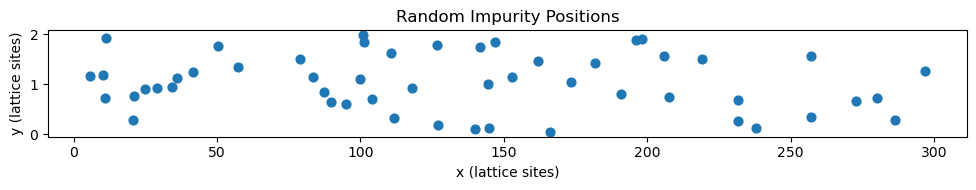

In [165]:
#print(Rimp)

# plot impurity positions
plt.figure(figsize=(10, 2))
plt.scatter(Rimp[:, 0], Rimp[:, 1], color='tab:blue', s=40)
plt.xlabel("x (lattice sites)")
plt.ylabel("y (lattice sites)")
plt.title("Random Impurity Positions")
plt.gca().set_aspect('auto')
plt.tight_layout()
plt.show()

In [166]:

# ======================================================================
# 4. Disorder potential
# ======================================================================
#Lambda_dis = 180.0  # decay length (Å)
Lambda_dis = ax/0.2222222

def fVd(x):
    """Exponential decay function."""
    return np.exp(-x / Lambda_dis)

def generate_Vdis(Nx, Ny, Rimp, ax, ay):
    """Generate smooth random disorder potential."""
    Nimp = len(Rimp)
    vtp = np.zeros((Nx, Ny), dtype=float)

    x_grid = np.arange(1, Nx + 1)[:, None]
    
    if Ny == 0:
        y_grid = np.zeros(1)
        
    else:
        y_grid = np.arange(1, Ny + 1)[None, :]
        

    for kk in range(Nimp):
        sign = (-1)**(kk + 1)
        #sign = np.random.choice([1,-1]) #<--- use this instead?
        dd = np.sqrt((x_grid - Rimp[kk, 0])**2 * ax**2 +
                     (y_grid - Rimp[kk, 1])**2 * ay**2)
        vtp += sign * fVd(dd)

    # subtract mean and normalize variance
    vtp -= np.mean(vtp)
    vtp /= np.sqrt(np.mean(vtp**2))
    return vtp

In [167]:
Vdis = generate_Vdis(Nx, Ny, Rimp, ax, ay)

# Construct Vdis4 (2Ny × Nx)
v2 = np.zeros((Nx, 2 * Ny))
for ii in range(Nx):
    jj_index = (np.arange(1, 2 * Ny + 1) // 2)
    v2[ii, :] = Vdis[ii, np.clip(jj_index, 0, Ny - 1)]
Vdis4 = np.hstack((v2, -v2))


Vdis.shape

(300, 1)

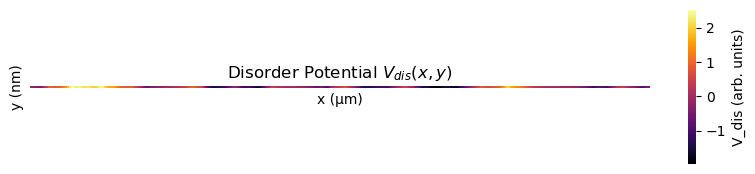

In [168]:
# ======================================================================
# 5. Plot Vdis (DensityPlot)
# ======================================================================

plt.figure(figsize=(10, 2))
sns.heatmap(
    Vdis.T,
    cmap="inferno",
    cbar=True,
    cbar_kws={'label': 'V_dis (arb. units)'},
    xticklabels=False,
    yticklabels=False
    
)
plt.xlabel("x (μm)")
plt.ylabel("y (nm)")
plt.title("Disorder Potential $V_{dis}(x, y)$")
plt.gca().set_aspect(0.75)
plt.show()

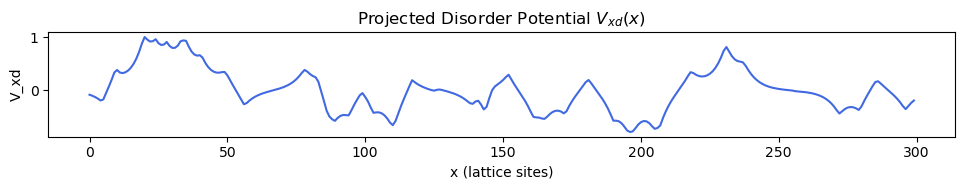

ΔVd = -0.0000
<Vxd²> = 0.1574


In [169]:
# ======================================================================
# 6. 1D projection: Vxd = sum_y Vdis(x, y) * Y0(y)
# ======================================================================
Y0 = np.ones(Ny)
Vxd = np.array([np.dot(Vdis[ii, :], Y0) for ii in range(Nx)])
Vxd = Vxd/np.max(np.abs(Vxd))

plt.figure(figsize=(10, 2))
plt.plot(np.arange(Nx), Vxd, color='royalblue')
plt.xlabel("x (lattice sites)")
plt.ylabel("V_xd")
plt.title("Projected Disorder Potential $V_{xd}(x)$")
plt.gca().set_aspect('auto')
plt.tight_layout()
plt.show()

# mean and variance
DeltaVd = np.mean(Vxd)
VarVd = np.mean(Vxd**2)
print(f"ΔVd = {DeltaVd:.4f}")
print(f"<Vxd²> = {VarVd:.4f}")

In [170]:
dir = '/home/pseudonym/code/Nonlocal_Conductance/Nonlocality-of-local-Andreev-conductances-as-a-probe-for-topological-Majorana-wires/Run_Files'
pth = Path(dir, 'Vdis4.npz')
np.savez(pth, Vdisx = Vxd)

In [171]:
import helpers as hp

dataloaded = hp.initialize_vdis_from_data(pth)

